In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy.stats import *
import h3
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from math import floor
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

In [2]:
ride_columns = ['accepted_driver_id', 'created_at', 'passenger_id', 'source_lat',
       'source_lng', 'destination_lat', 'destination_lng', 'eta', 'provider',
       'ata', 'id', 'city']

khatkesh_columns = ['ride_id','driver_id','a_t_a_result.arrival_a_t_a','a_t_a_result.boarding_a_t_a','a_t_a_result.ride_a_t_a','a_t_a_result.arrival_probe_result.probe.point.lat','a_t_a_result.arrival_probe_result.probe.point.lon','a_t_a_result.arrival_probe_result.probe.timestamp','a_t_a_result.arrival_probe_result.confidence','a_t_a_result.arrival_probe_result.h3_index', 'a_t_a_result.arrival_probe_result.k_ring_level','a_t_a_result.boarding_probe_result.probe.point.lat','a_t_a_result.boarding_probe_result.probe.point.lon','a_t_a_result.boarding_probe_result.probe.timestamp','a_t_a_result.boarding_probe_result.confidence','a_t_a_result.boarding_probe_result.h3_index','a_t_a_result.boarding_probe_result.k_ring_level','a_t_a_result.final_destination_probe_result.probe.point.lat','a_t_a_result.final_destination_probe_result.probe.point.lon','a_t_a_result.final_destination_probe_result.probe.timestamp','a_t_a_result.final_destination_probe_result.confidence','a_t_a_result.final_destination_probe_result.h3_index','a_t_a_result.final_destination_probe_result.k_ring_level','a_t_a_result.destination_probe_result.probe.point.lat','a_t_a_result.destination_probe_result.probe.point.lon','a_t_a_result.destination_probe_result.probe.timestamp','a_t_a_result.destination_probe_result.confidence','a_t_a_result.destination_probe_result.h3_index','a_t_a_result.destination_probe_result.k_ring_level','a_t_a_result.extra_destination_probe_result.probe.point.lat','a_t_a_result.extra_destination_probe_result.probe.point.lon','a_t_a_result.extra_destination_probe_result.probe.timestamp','a_t_a_result.extra_destination_probe_result.confidence','a_t_a_result.extra_destination_probe_result.h3_index','a_t_a_result.extra_destination_probe_result.k_ring_level','pickup_a_d_d_result.distance','pickup_a_d_d_result.confidence','pickup_a_d_d_result.route_ratio','pickup_a_d_d_result.g_p_s_ratio','ride_a_d_d_result.distance','ride_a_d_d_result.confidence','ride_a_d_d_result.route_ratio','ride_a_d_d_result.g_p_s_ratio','total_a_d_d_confidence','in_ride_allotment','e_d_d','clickhouse_time','hash']

train_dates = ['2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
               '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05',
               '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10']

train_holidays = ['2022-08-07', '2022-08-08']

test_dates = ['2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17',
              '2022-09-18', '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24',
              '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01',
              '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08',
              '2022-10-09']

test_holidays = ['2022-09-17', '2022-09-25', '2022-09-27', '2022-10-05']

In [3]:
# for iddate, date in enumerate(train_dates):
#     header = False
#     rides_df = pd.read_csv('../rides_' + date + '.csv', names=ride_columns)
#     rides_df.rename(columns={'id': 'ride_id'}, inplace=True)
#
#     files = ['../khatkesh_' + date + '_.csv']
#     if iddate+1 != len(train_dates):
#         files.append('../khatkesh_' + train_dates[iddate+1] + '_.csv')
#     # THE IGNORE INDEX IS WRONG MAYBE
#     khatkesh_df = pd.concat((pd.read_csv(f, names=khatkesh_columns) for f in files), ignore_index=True)
#
#     rides_khatkesh = pd.merge(rides_df, khatkesh_df, on="ride_id")
#
#     print(len(rides_df))
#     print(date)
#     print(len(rides_khatkesh))
#
#     if iddate == 0:
#         header = True
#
#     rides_khatkesh.to_csv('../rides_train.csv', mode='a', header=header, index=False)

In [4]:
rides_train = pd.read_csv('../rides_train.csv')
rides_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063341 entries, 0 to 4063340
Data columns (total 59 columns):
 #   Column                                                       Dtype  
---  ------                                                       -----  
 0   accepted_driver_id                                           int64  
 1   created_at                                                   object 
 2   passenger_id                                                 int64  
 3   source_lat                                                   float64
 4   source_lng                                                   float64
 5   destination_lat                                              float64
 6   destination_lng                                              float64
 7   eta                                                          int64  
 8   provider                                                     object 
 9   ata                                                          int64  

In [5]:
rides_test = pd.read_csv('../rides_test.csv')
rides_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729988 entries, 0 to 2729987
Data columns (total 59 columns):
 #   Column                                                       Dtype  
---  ------                                                       -----  
 0   accepted_driver_id                                           int64  
 1   created_at                                                   object 
 2   passenger_id                                                 int64  
 3   source_lat                                                   float64
 4   source_lng                                                   float64
 5   destination_lat                                              float64
 6   destination_lng                                              float64
 7   eta                                                          int64  
 8   provider                                                     object 
 9   ata                                                          int64  

In [6]:
rides_train_p4 = rides_train[rides_train['eta'] >= 1800]
rides_train_p4

,accepted_driver_id,created_at,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,provider,ata,...,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,clickhouse_time,hash
1,1630622,2022-08-02 21:19:50,24944157,35.753071,51.364353,35.801231,51.452614,1886,smapp-same-dc,1678,...,0.005714,28.000000,0.973821,0.0,0.840000,0.978096,0.0,0.000000,2022-08-02 21:54:54,17518631764082474900
16,1733850,2022-08-02 18:48:21,18113917,35.801170,51.417953,35.774540,51.331562,2204,smapp-same-dc,2581,...,0.003676,13.838000,0.617575,0.0,0.102941,0.684035,0.0,0.000000,2022-08-02 19:40:51,6718141937521421034
21,2942776,2022-08-02 20:09:35,15340963,35.617275,51.488651,35.724304,51.501282,2083,smapp-same-dc,1833,...,0.005525,33.257999,0.966835,0.0,0.878453,0.971940,0.0,0.000000,2022-08-02 20:45:39,9118069446153719521
40,2731688,2022-08-02 20:55:26,2043592,35.759720,51.262569,35.725605,51.444698,2185,smapp-same-dc,2293,...,0.004405,43.938831,0.976005,0.0,0.973568,0.979931,0.0,0.000000,2022-08-02 21:43:43,4640629599265281559
41,558365,2022-08-02 10:07:26,38602549,35.544151,51.222370,35.753899,51.145321,2532,smapp-same-dc,2571,...,0.003413,47.014339,0.495764,0.0,0.071672,0.496288,0.0,0.000000,2022-08-02 10:55:30,15347317208377558354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063308,4100368,2022-09-10 08:43:43,23085905,35.686737,51.378422,35.766529,51.479244,1903,smapp-same-dc,2247,...,0.004386,30.699947,0.897787,0.0,0.951754,0.912274,0.0,20.017000,2022-09-10 09:34:47,6285336365528391845
4063311,2360511,2022-09-10 00:53:09,24484463,35.667233,51.344719,35.846325,51.005749,2427,smapp-same-dc,2220,...,0.003953,52.319000,0.652545,0.0,0.162055,0.698573,0.0,44.632999,2022-09-10 01:38:42,5982922617154083351
4063332,2779592,2022-09-10 15:04:43,43527985,35.588966,51.422379,35.733543,51.345242,1969,smapp-same-dc,2221,...,0.004444,40.393002,0.519409,0.0,0.066667,0.532460,0.0,28.209999,2022-09-10 15:50:30,16403387582631044042
4063336,3629,2022-09-10 10:59:52,28110479,35.683701,51.372459,35.799290,51.477062,2052,smapp-same-dc,2532,...,0.003021,22.107664,0.439463,0.0,0.063444,0.501275,0.0,24.957001,2022-09-10 12:05:12,4744731905255557123


In [7]:
rides_test_p4 = rides_test[rides_test['eta'] >= 1800]
rides_test_p4

,accepted_driver_id,created_at,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,provider,ata,...,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,clickhouse_time,hash
6,276394,2022-09-11 12:25:04,1130420,35.780571,51.356174,35.628082,51.351501,1894,smapp-same-dc,1963,...,0.005051,25.871000,0.558019,0.0,0.146465,0.610596,0.000,25.691999,2022-09-11 13:00:48,9344030596630141528
17,3564404,2022-09-11 20:54:38,20882457,35.640404,51.416351,35.768814,51.276939,2944,smapp-same-dc,2778,...,0.003559,65.590630,0.834837,0.0,0.868327,0.857004,0.000,40.091000,2022-09-11 22:09:37,13862046135803300111
20,2972216,2022-09-11 07:07:26,41413761,35.356205,51.641312,35.601074,51.435585,2472,smapp-same-dc,2877,...,0.003610,40.578999,0.546872,0.0,0.104693,0.609309,0.000,38.662998,2022-09-11 08:02:38,5652449490027755269
23,4288367,2022-09-11 22:03:11,47543504,35.351887,51.645844,35.599098,51.442066,2364,smapp-same-dc,2719,...,0.004000,65.080360,0.888148,0.0,0.896000,0.906676,0.000,38.363998,2022-09-11 23:02:15,9004574699344913211
24,785560,2022-09-11 09:02:41,21514168,35.720486,51.309761,35.796368,51.514473,2362,smapp-same-dc,2410,...,0.004425,27.839001,0.568824,0.0,0.092920,0.653371,0.000,28.323000,2022-09-11 09:50:47,17365459658581884520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729963,983182,2022-10-09 14:43:23,20553284,35.721123,51.510109,35.521900,51.249054,2660,smapp-same-dc,6153,...,0.001706,128.636993,0.981323,0.0,0.998294,0.983652,0.000,43.882999,2022-10-09 16:35:42,11470021632531286296
2729966,35629,2022-10-09 15:54:14,3406353,35.764214,51.475269,35.750290,51.286972,2004,smapp-same-dc,3809,...,0.002632,40.758999,0.984237,0.0,0.984211,0.986524,0.000,19.643000,2022-10-09 17:08:56,5916495388916790202
2729968,4373409,2022-10-09 12:37:31,2737984,35.775448,51.384750,35.719559,51.607353,2170,smapp-same-dc,2953,...,0.003378,52.777908,0.911451,0.0,0.891892,0.924451,1.448,29.955999,2022-10-09 13:36:01,12320934774556909350
2729976,4180315,2022-10-09 09:28:07,38218151,35.735134,51.420135,35.485798,51.686787,3134,smapp-same-dc,4588,...,0.002364,85.375381,0.988441,0.0,0.978723,0.989872,0.000,43.558998,2022-10-09 10:55:43,11953691384932500369


There are some duplicates in the data

In [8]:
rides_train_p4 = rides_train_p4.drop_duplicates(subset=['ride_id', 'ata'])
len(rides_train_p4)

514839

In [9]:
rides_test_p4 = rides_test_p4.drop_duplicates(subset=['ride_id', 'ata'])
len(rides_test_p4)

332061

In [10]:
# for iddate, date in enumerate(test_dates):
#     header = False
#     rides_df = pd.read_csv('../rides_' + date + '.csv', names=ride_columns)
#     rides_df.rename(columns={'id': 'ride_id'}, inplace=True)
#
#     files = ['../khatkesh_' + date + '_.csv']
#     if iddate+1 != len(test_dates):
#         files.append('../khatkesh_' + test_dates[iddate+1] + '_.csv')
#     # THE IGNORE INDEX IS WRONG MAYBE
#     khatkesh_df = pd.concat((pd.read_csv(f, names=khatkesh_columns) for f in files), ignore_index=True)
#
#     rides_khatkesh = pd.merge(rides_df, khatkesh_df, on="ride_id")
#
#     print(len(rides_df))
#     print(date)
#     print(len(rides_khatkesh))
#
#     if iddate == 0:
#         header = True
#
#     rides_khatkesh.to_csv('../rides_test.csv', mode='a', header=header, index=False)

In [11]:
rides_train_p4 = rides_train_p4[(rides_train_p4['eta'] > 180) &
                                (rides_train_p4['eta'] < 10800) &
                                (rides_train_p4['a_t_a_result.ride_a_t_a'] > 180) &
                                (rides_train_p4['a_t_a_result.ride_a_t_a'] < 10800)]
rides_train_p4.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,5.132660e+05,5.132660e+05,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,5.132660e+05,513266.0,...,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,513266.000000,5.132660e+05
mean,2.052076e+06,2.542970e+07,35.682093,51.396489,35.693895,51.340904,2496.019686,2995.289856,4.827573e+09,1.0,...,0.000193,0.003340,51.976315,0.824027,0.000012,0.698335,0.835393,0.055390,8.390746,9.217479e+18
std,1.384086e+06,1.822361e+07,0.104089,0.152049,0.107322,0.205802,694.146171,1170.603664,5.961566e+07,0.0,...,0.011157,0.001517,28.525724,0.168117,0.000284,0.331778,0.160291,1.149136,16.564012,5.325390e+18
min,0.000000e+00,1.100000e+01,35.186329,50.900448,33.992180,49.698254,1800.000000,206.000000,4.714479e+09,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.162610e+12
25%,6.983410e+05,6.466300e+06,35.641220,51.321495,35.654217,51.243610,2002.000000,2225.000000,4.778560e+09,1.0,...,0.000000,0.002564,33.532001,0.711429,0.000000,0.460481,0.737998,0.000000,0.000000,4.606262e+18
50%,2.115911e+06,2.626258e+07,35.713772,51.402451,35.717728,51.387814,2286.000000,2716.000000,4.829735e+09,1.0,...,0.000000,0.003472,46.855902,0.890067,0.000000,0.860759,0.896658,0.000000,0.000000,9.217168e+18
75%,3.293086e+06,4.086694e+07,35.754856,51.461155,35.759948,51.454262,2767.000000,3456.000000,4.874188e+09,1.0,...,0.000000,0.004329,64.639000,0.959883,0.000000,0.964758,0.962513,0.000000,12.464750,1.382594e+19
max,4.330826e+06,5.737685e+07,35.839874,52.794945,36.656895,53.376816,10528.000000,28079.000000,4.933844e+09,1.0,...,1.000000,0.045455,8428.820312,1.000000,0.023997,1.000000,1.000000,732.436646,192.143997,1.844667e+19


In [12]:
rides_train_p4 = rides_train_p4[rides_train_p4['ride_a_d_d_result.confidence'] > 0.6]
rides_train_p4.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,4.294170e+05,4.294170e+05,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,4.294170e+05,429417.0,...,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,4.294170e+05
mean,2.068551e+06,2.536035e+07,35.682763,51.396537,35.694780,51.341683,2488.431424,2989.498520,4.827887e+09,1.0,...,0.000138,0.003502,54.882286,0.883479,0.000006,0.805651,0.892133,0.062530,8.359469,9.216641e+18
std,1.388070e+06,1.822495e+07,0.103548,0.150756,0.105379,0.203733,686.953959,1160.621526,5.947612e+07,0.0,...,0.009316,0.001374,25.905670,0.106526,0.000164,0.228164,0.098338,1.249484,16.432228,5.324820e+18
min,0.000000e+00,1.100000e+01,35.186329,50.900448,34.527206,49.698254,1800.000000,206.000000,4.714479e+09,1.0,...,0.000000,0.000000,0.518000,0.600000,0.000000,0.019928,0.071867,0.000000,0.000000,2.162610e+12
25%,7.129390e+05,6.376887e+06,35.642231,51.321552,35.655174,51.246811,2000.000000,2223.000000,4.778853e+09,1.0,...,0.000000,0.002732,36.233002,0.823008,0.000000,0.718876,0.836533,0.000000,0.000000,4.601857e+18
50%,2.136973e+06,2.613987e+07,35.714275,51.402256,35.718239,51.388309,2280.000000,2712.000000,4.830384e+09,1.0,...,0.000000,0.003571,49.673256,0.918558,0.000000,0.906890,0.923619,0.000000,0.000000,9.213324e+18
75%,3.318065e+06,4.077141e+07,35.755016,51.461029,35.760185,51.454212,2755.000000,3450.000000,4.874500e+09,1.0,...,0.000000,0.004405,67.780228,0.968288,0.000000,0.972763,0.970292,0.000000,12.726000,1.382504e+19
max,4.330826e+06,5.737685e+07,35.839859,52.794945,36.650635,52.890411,10528.000000,24731.000000,4.933844e+09,1.0,...,1.000000,0.045455,313.610565,1.000000,0.021476,1.000000,1.000000,732.436646,192.143997,1.844667e+19


In [13]:
rides_test_p4 = rides_test_p4[rides_test_p4['ride_a_d_d_result.confidence'] > 0.6]
rides_test_p4.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,2.788430e+05,2.788430e+05,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,2.788430e+05,278843.0,...,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,278843.000000,2.788430e+05
mean,2.116232e+06,2.609059e+07,35.676287,51.397066,35.689944,51.337101,2516.283145,3073.855410,5.011934e+09,1.0,...,0.000098,0.003499,58.027782,0.886101,0.000006,0.821759,0.894554,0.021714,34.136089,9.237461e+18
std,1.418592e+06,1.845365e+07,0.107658,0.157915,0.115357,0.216338,739.017837,1397.028177,4.430596e+07,0.0,...,0.007260,0.001417,28.392361,0.106474,0.000168,0.225150,0.098159,0.273325,17.917391,5.330637e+18
min,4.000000e+01,4.900000e+01,35.189159,50.900494,32.670967,47.098091,1800.000000,197.000000,4.933925e+09,1.0,...,0.000000,0.000000,1.536007,0.600000,0.000000,0.002274,0.069230,0.000000,0.330000,1.176974e+13
25%,7.343055e+05,7.001014e+06,35.632809,51.317381,35.648270,51.226746,2004.000000,2209.000000,4.973497e+09,1.0,...,0.000000,0.002674,38.513920,0.826009,0.000000,0.753846,0.839193,0.000000,21.434000,4.608636e+18
50%,2.178018e+06,2.721694e+07,35.708900,51.401840,35.714710,51.382637,2298.000000,2725.000000,5.013222e+09,1.0,...,0.000000,0.003559,52.609707,0.922212,0.000000,0.925072,0.927093,0.000000,30.336000,9.252629e+18
75%,3.385968e+06,4.166389e+07,35.753109,51.465429,35.758526,51.456905,2800.000000,3530.000000,5.051641e+09,1.0,...,0.000000,0.004425,71.319210,0.970838,0.000000,0.978723,0.972556,0.000000,42.875000,1.386298e+19
max,4.421542e+06,5.813654e+07,35.839905,52.796974,37.795307,53.601524,19173.000000,42949.000000,5.083611e+09,1.0,...,1.000000,0.047619,634.343750,1.000000,0.015040,1.000000,1.000000,51.702080,517.880005,1.844673e+19


In [14]:
rides_train_p4 = rides_train_p4[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides_train_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
1,1886,1678,1686,2022-08-02 21:19:50,35.753071,51.364353,35.801231,51.452614,0.000000,2022-08-02 21:54:54
16,2204,2581,2673,2022-08-02 18:48:21,35.801170,51.417953,35.774540,51.331562,0.000000,2022-08-02 19:40:51
21,2083,1833,1808,2022-08-02 20:09:35,35.617275,51.488651,35.724304,51.501282,0.000000,2022-08-02 20:45:39
40,2185,2293,2265,2022-08-02 20:55:26,35.759720,51.262569,35.725605,51.444698,0.000000,2022-08-02 21:43:43
58,2273,2305,2260,2022-08-02 20:00:03,35.721745,51.335915,35.767059,51.456818,0.000000,2022-08-02 20:48:05
...,...,...,...,...,...,...,...,...,...,...
4063291,2106,2353,2325,2022-09-10 18:06:42,35.718906,51.183876,35.767773,50.962521,26.833000,2022-09-10 18:51:40
4063306,1824,1795,1785,2022-09-10 17:27:22,35.768711,51.768398,35.749062,51.517361,32.625000,2022-09-10 18:05:34
4063308,1903,2247,2276,2022-09-10 08:43:43,35.686737,51.378422,35.766529,51.479244,20.017000,2022-09-10 09:34:47
4063311,2427,2220,2202,2022-09-10 00:53:09,35.667233,51.344719,35.846325,51.005749,44.632999,2022-09-10 01:38:42


In [15]:
rides_test_p4 = rides_test_p4[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides_test_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
17,2944,2778,2750,2022-09-11 20:54:38,35.640404,51.416351,35.768814,51.276939,40.091000,2022-09-11 22:09:37
23,2364,2719,2491,2022-09-11 22:03:11,35.351887,51.645844,35.599098,51.442066,38.363998,2022-09-11 23:02:15
28,2436,2816,3452,2022-09-11 14:17:32,35.635067,51.381229,35.780197,51.467113,30.767000,2022-09-11 15:24:33
36,2132,2491,2592,2022-09-11 12:36:45,35.774742,51.369663,35.672554,51.479824,29.271000,2022-09-11 13:26:27
40,2776,2386,2333,2022-09-11 15:26:48,35.373806,51.234982,35.590813,51.437553,44.577999,2022-09-11 16:34:11
...,...,...,...,...,...,...,...,...,...,...
2729963,2660,6153,5852,2022-10-09 14:43:23,35.721123,51.510109,35.521900,51.249054,43.882999,2022-10-09 16:35:42
2729966,2004,3809,3793,2022-10-09 15:54:14,35.764214,51.475269,35.750290,51.286972,19.643000,2022-10-09 17:08:56
2729968,2170,2953,2956,2022-10-09 12:37:31,35.775448,51.384750,35.719559,51.607353,29.955999,2022-10-09 13:36:01
2729976,3134,4588,4224,2022-10-09 09:28:07,35.735134,51.420135,35.485798,51.686787,43.558998,2022-10-09 10:55:43


In [16]:
rides_train_p4['source_h3_4'] = rides_train_p4.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
rides_train_p4['dest_h3_4'] = rides_train_p4.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)
rides_train_p4['hour'] = rides_train_p4.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)
rides_train_p4['holiday'] = rides_train_p4.apply(lambda row: int(row.created_at.split()[0] in train_holidays), axis=1)
rides_train_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,source_h3_4,dest_h3_4,hour,holiday
1,1886,1678,1686,2022-08-02 21:19:50,35.753071,51.364353,35.801231,51.452614,0.000000,2022-08-02 21:54:54,842cf31ffffffff,842cf31ffffffff,93.330556,0
16,2204,2581,2673,2022-08-02 18:48:21,35.801170,51.417953,35.774540,51.331562,0.000000,2022-08-02 19:40:51,842cf31ffffffff,842cf31ffffffff,90.805833,0
21,2083,1833,1808,2022-08-02 20:09:35,35.617275,51.488651,35.724304,51.501282,0.000000,2022-08-02 20:45:39,842cf31ffffffff,842cf31ffffffff,92.159722,0
40,2185,2293,2265,2022-08-02 20:55:26,35.759720,51.262569,35.725605,51.444698,0.000000,2022-08-02 21:43:43,842cf31ffffffff,842cf31ffffffff,92.923889,0
58,2273,2305,2260,2022-08-02 20:00:03,35.721745,51.335915,35.767059,51.456818,0.000000,2022-08-02 20:48:05,842cf31ffffffff,842cf31ffffffff,92.000833,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063291,2106,2353,2325,2022-09-10 18:06:42,35.718906,51.183876,35.767773,50.962521,26.833000,2022-09-10 18:51:40,842cf31ffffffff,842cf3dffffffff,18.111667,0
4063306,1824,1795,1785,2022-09-10 17:27:22,35.768711,51.768398,35.749062,51.517361,32.625000,2022-09-10 18:05:34,842cf33ffffffff,842cf31ffffffff,17.456111,0
4063308,1903,2247,2276,2022-09-10 08:43:43,35.686737,51.378422,35.766529,51.479244,20.017000,2022-09-10 09:34:47,842cf31ffffffff,842cf31ffffffff,8.728611,0
4063311,2427,2220,2202,2022-09-10 00:53:09,35.667233,51.344719,35.846325,51.005749,44.632999,2022-09-10 01:38:42,842cf31ffffffff,842cf39ffffffff,0.885833,0


In [17]:
rides_test_p4['source_h3_4'] = rides_test_p4.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
rides_test_p4['dest_h3_4'] = rides_test_p4.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)
rides_test_p4['hour'] = rides_test_p4.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)
rides_test_p4['holiday'] = rides_test_p4.apply(lambda row: int(row.created_at.split()[0] in test_holidays), axis=1)
rides_test_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,source_h3_4,dest_h3_4,hour,holiday
17,2944,2778,2750,2022-09-11 20:54:38,35.640404,51.416351,35.768814,51.276939,40.091000,2022-09-11 22:09:37,842cf31ffffffff,842cf31ffffffff,44.910556,0
23,2364,2719,2491,2022-09-11 22:03:11,35.351887,51.645844,35.599098,51.442066,38.363998,2022-09-11 23:02:15,842cf37ffffffff,842cf31ffffffff,46.053056,0
28,2436,2816,3452,2022-09-11 14:17:32,35.635067,51.381229,35.780197,51.467113,30.767000,2022-09-11 15:24:33,842cf31ffffffff,842cf31ffffffff,38.292222,0
36,2132,2491,2592,2022-09-11 12:36:45,35.774742,51.369663,35.672554,51.479824,29.271000,2022-09-11 13:26:27,842cf31ffffffff,842cf31ffffffff,36.612500,0
40,2776,2386,2333,2022-09-11 15:26:48,35.373806,51.234982,35.590813,51.437553,44.577999,2022-09-11 16:34:11,842cf35ffffffff,842cf31ffffffff,39.446667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729963,2660,6153,5852,2022-10-09 14:43:23,35.721123,51.510109,35.521900,51.249054,43.882999,2022-10-09 16:35:42,842cf31ffffffff,842cf35ffffffff,39.723056,0
2729966,2004,3809,3793,2022-10-09 15:54:14,35.764214,51.475269,35.750290,51.286972,19.643000,2022-10-09 17:08:56,842cf31ffffffff,842cf31ffffffff,40.903889,0
2729968,2170,2953,2956,2022-10-09 12:37:31,35.775448,51.384750,35.719559,51.607353,29.955999,2022-10-09 13:36:01,842cf31ffffffff,842cf31ffffffff,37.625278,0
2729976,3134,4588,4224,2022-10-09 09:28:07,35.735134,51.420135,35.485798,51.686787,43.558998,2022-10-09 10:55:43,842cf31ffffffff,842cf37ffffffff,34.468611,0


In [18]:
# , "e_d_d"
rides_train_p4_x = rides_train_p4[["eta", "source_h3_4", "dest_h3_4", "hour", "holiday"]]
rides_train_p4_y = rides_train_p4["a_t_a_result.ride_a_t_a"]

In [19]:
# , "e_d_d"
rides_test_p4_x = rides_test_p4[["eta", "source_h3_4", "dest_h3_4", "hour", "holiday"]]
rides_test_p4_y = rides_test_p4["a_t_a_result.ride_a_t_a"]

In [20]:
dummy_train_rides = pd.get_dummies(rides_train_p4_x, prefix={'source_h3_4':'source_h3_4',
                                                             'dest_h3_4':'dest_h3_4'})
dummy_train_rides.describe()

,eta,hour,holiday,source_h3_4_842cd4bffffffff,source_h3_4_842cd59ffffffff,source_h3_4_842cd5bffffffff,source_h3_4_842cf31ffffffff,source_h3_4_842cf33ffffffff,source_h3_4_842cf35ffffffff,source_h3_4_842cf37ffffffff,...,dest_h3_4_842cf21ffffffff,dest_h3_4_842cf23ffffffff,dest_h3_4_842cf25ffffffff,dest_h3_4_842cf27ffffffff,dest_h3_4_842cf31ffffffff,dest_h3_4_842cf33ffffffff,dest_h3_4_842cf35ffffffff,dest_h3_4_842cf37ffffffff,dest_h3_4_842cf39ffffffff,dest_h3_4_842cf3dffffffff
count,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,...,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.000000,429417.00000,429417.000000,429417.000000
mean,2488.431424,82.662780,0.013341,0.000759,0.002408,0.000079,0.792789,0.030120,0.075577,0.033098,...,0.000102,0.000002,0.000002,0.000389,0.694095,0.022500,0.060366,0.02512,0.024161,0.164761
std,686.953959,44.530640,0.114732,0.027543,0.049011,0.008898,0.405309,0.170917,0.264320,0.178894,...,0.010122,0.001526,0.001526,0.019717,0.460790,0.148304,0.238163,0.15649,0.153548,0.370965
min,1800.000000,0.001389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2000.000000,43.219167,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2280.000000,86.279722,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2755.000000,115.541389,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,10528.000000,167.413889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [21]:
dummy_train_rides

,eta,hour,holiday,source_h3_4_842cd4bffffffff,source_h3_4_842cd59ffffffff,source_h3_4_842cd5bffffffff,source_h3_4_842cf31ffffffff,source_h3_4_842cf33ffffffff,source_h3_4_842cf35ffffffff,source_h3_4_842cf37ffffffff,...,dest_h3_4_842cf21ffffffff,dest_h3_4_842cf23ffffffff,dest_h3_4_842cf25ffffffff,dest_h3_4_842cf27ffffffff,dest_h3_4_842cf31ffffffff,dest_h3_4_842cf33ffffffff,dest_h3_4_842cf35ffffffff,dest_h3_4_842cf37ffffffff,dest_h3_4_842cf39ffffffff,dest_h3_4_842cf3dffffffff
1,1886,93.330556,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16,2204,90.805833,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
21,2083,92.159722,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
40,2185,92.923889,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
58,2273,92.000833,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063291,2106,18.111667,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4063306,1824,17.456111,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4063308,1903,8.728611,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4063311,2427,0.885833,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
print(np.count_nonzero(dummy_train_rides, axis=0))
print(dummy_train_rides.columns)

[429417 429417   5729    326   1034     34 340437  12934  32454  14213
  27985     27      1      2      1    412      1    856     56    147
    105   2037      1      2      3     44      1      1    167 298056
   9662  25922  10787  10375  70751]
Index(['eta', 'hour', 'holiday', 'source_h3_4_842cd4bffffffff',
       'source_h3_4_842cd59ffffffff', 'source_h3_4_842cd5bffffffff',
       'source_h3_4_842cf31ffffffff', 'source_h3_4_842cf33ffffffff',
       'source_h3_4_842cf35ffffffff', 'source_h3_4_842cf37ffffffff',
       'source_h3_4_842cf3dffffffff', 'dest_h3_4_842c89bffffffff',
       'dest_h3_4_842cc61ffffffff', 'dest_h3_4_842cc63ffffffff',
       'dest_h3_4_842cc67ffffffff', 'dest_h3_4_842cd4bffffffff',
       'dest_h3_4_842cd4dffffffff', 'dest_h3_4_842cd59ffffffff',
       'dest_h3_4_842cd5bffffffff', 'dest_h3_4_842cf01ffffffff',
       'dest_h3_4_842cf05ffffffff', 'dest_h3_4_842cf07ffffffff',
       'dest_h3_4_842cf09ffffffff', 'dest_h3_4_842cf0dffffffff',
       'dest_h3_4_842c

In [23]:
geo_noise = np.count_nonzero(dummy_train_rides, axis=0) < 100

cols = dummy_train_rides.columns
for col, noise in zip(cols, geo_noise):
    if noise:
        # DOESN'T REINDEX
        # remove the rows where rides_train_p4_x is in the noisy geo (geo is 1)
        rides_train_p4_x = rides_train_p4_x[dummy_train_rides[col] == 0]
        rides_train_p4_y = rides_train_p4_y[dummy_train_rides[col] == 0]

rides_train_p4_x.describe()

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_48877/1973543715.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rides_train_p4_x = rides_train_p4_x[dummy_train_rides[col] == 0]


,eta,hour,holiday
count,429245.000000,429245.000000,429245.000000
mean,2486.922401,82.660741,0.013333
std,682.280550,44.528344,0.114695
min,1800.000000,0.001389,0.000000
25%,1999.000000,43.219722,0.000000
50%,2280.000000,86.278611,0.000000
75%,2754.000000,115.539167,0.000000
max,10333.000000,167.413889,1.000000


In [24]:
ohe = ColumnTransformer(
    [('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False),['source_h3_4', 'dest_h3_4'])],
    remainder = 'passthrough'
    ).fit(rides_train_p4_x)

In [25]:
ohe.get_feature_names_out()

array(['OHE__source_h3_4_842cd4bffffffff',
       'OHE__source_h3_4_842cd59ffffffff',
       'OHE__source_h3_4_842cf31ffffffff',
       'OHE__source_h3_4_842cf33ffffffff',
       'OHE__source_h3_4_842cf35ffffffff',
       'OHE__source_h3_4_842cf37ffffffff',
       'OHE__source_h3_4_842cf3dffffffff',
       'OHE__dest_h3_4_842cd4bffffffff', 'OHE__dest_h3_4_842cd59ffffffff',
       'OHE__dest_h3_4_842cf01ffffffff', 'OHE__dest_h3_4_842cf05ffffffff',
       'OHE__dest_h3_4_842cf07ffffffff', 'OHE__dest_h3_4_842cf27ffffffff',
       'OHE__dest_h3_4_842cf31ffffffff', 'OHE__dest_h3_4_842cf33ffffffff',
       'OHE__dest_h3_4_842cf35ffffffff', 'OHE__dest_h3_4_842cf37ffffffff',
       'OHE__dest_h3_4_842cf39ffffffff', 'OHE__dest_h3_4_842cf3dffffffff',
       'remainder__eta', 'remainder__hour', 'remainder__holiday'],
      dtype=object)

In [26]:
rides_train_p4_x = ohe.transform(rides_train_p4_x)

In [27]:
rides_test_p4_x = ohe.transform(rides_test_p4_x)

In [28]:
reg_p4 = LinearRegression().fit(rides_train_p4_x, rides_train_p4_y)

In [29]:
print(reg_p4.coef_)
print(reg_p4.intercept_)

[-6.18320117e+11 -6.18320117e+11 -6.18320117e+11 -6.18320117e+11
 -6.18320117e+11 -6.18320117e+11 -6.18320117e+11 -2.74586512e+10
 -2.74586512e+10 -2.74586514e+10 -2.74586514e+10 -2.74586512e+10
 -2.74586511e+10 -2.74586510e+10 -2.74586512e+10 -2.74586512e+10
 -2.74586512e+10 -2.74586512e+10 -2.74586512e+10  1.24164941e+00
 -5.56984845e-01 -1.74760729e+02]
645778768066.081


In [30]:
ata_train_pred = reg_p4.predict(rides_train_p4_x)
ata_test_pred = reg_p4.predict(rides_test_p4_x)

In [31]:
rides_train_p4_x

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.88600000e+03, 9.33305556e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.20400000e+03, 9.08058333e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.08300000e+03, 9.21597222e+01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.90300000e+03, 8.72861111e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.42700000e+03, 8.85833333e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.85600000e+03, 1.06652778e+01, 0.00000000e+00]])

In [32]:
rides_test_p4_x

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.94400000e+03, 4.49105556e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.36400000e+03, 4.60530556e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.43600000e+03, 3.82922222e+01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.17000000e+03, 3.76252778e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.13400000e+03, 3.44686111e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.46600000e+03, 4.42686111e+01, 0.00000000e+00]])

In [33]:
known_h3_index = np.count_nonzero(rides_test_p4_x[:, 0:19], axis=1) == 2

In [34]:
rides_test_p4_y = rides_test_p4_y[known_h3_index]
rides_test_p4_x = rides_test_p4_x[known_h3_index]
ata_test_pred = ata_test_pred[known_h3_index]

# Visualization

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot: ylabel='Count'>

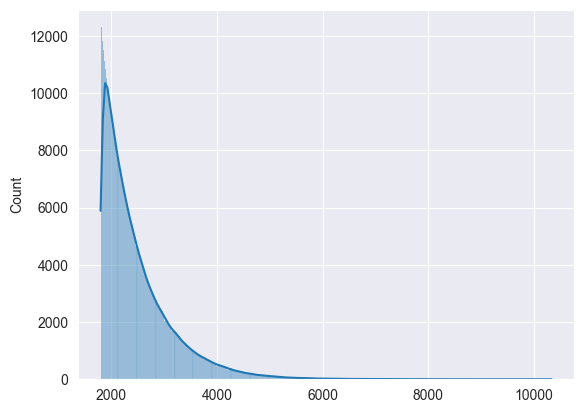

In [37]:
sns.histplot(data=rides_train_p4_x[:, 19], kde=True)

<AxesSubplot: ylabel='Count'>

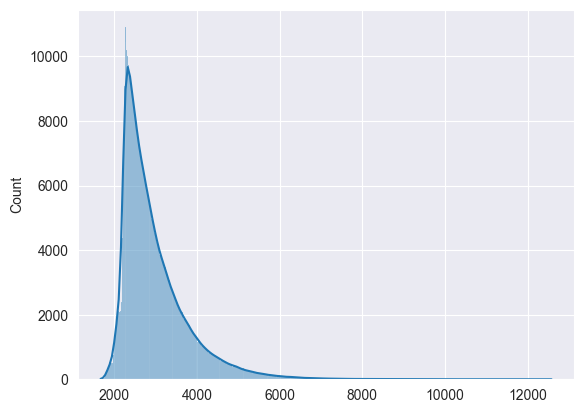

In [38]:
sns.histplot(data=ata_train_pred, kde=True)

<AxesSubplot: xlabel='a_t_a_result.ride_a_t_a', ylabel='Count'>

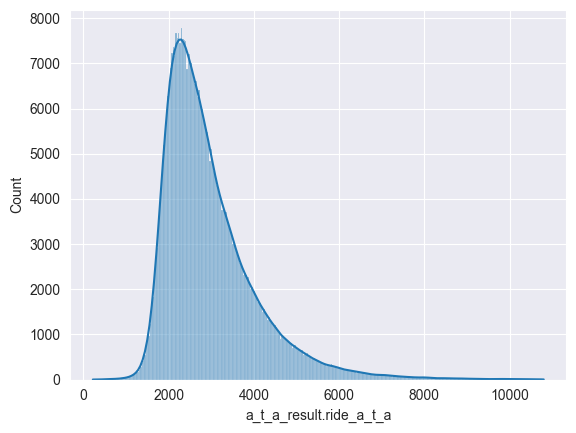

In [39]:
sns.histplot(data=rides_train_p4_y, kde=True)

<AxesSubplot: xlabel='a_t_a_result.ride_a_t_a', ylabel='Count'>

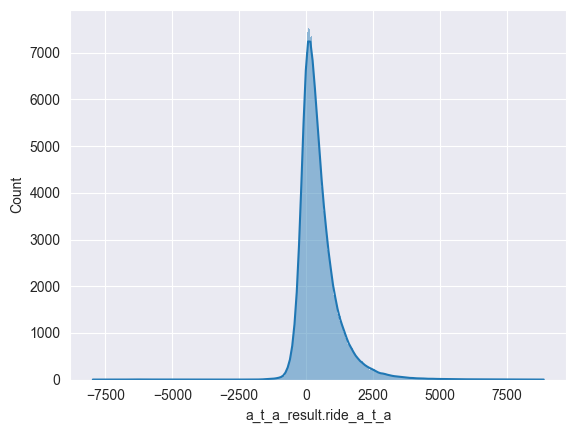

In [40]:
abs_eta_err = rides_train_p4_y - rides_train_p4_x[:, 19]
sns.histplot(data=abs_eta_err, kde=True)

In [44]:
a = abs_eta_err[(abs_eta_err > -500) & (abs_eta_err < 500)]
len(a)

264100

In [47]:
abs_eta_err.mean()

477.75312234271803

In [51]:
abs_eta_err.std()

746.6719410447356

In [53]:
abs_eta_err.kurtosis()

12.350605900365167

In [54]:
abs_eta_err.skew()

2.087055942490867

<AxesSubplot: xlabel='a_t_a_result.ride_a_t_a', ylabel='Count'>

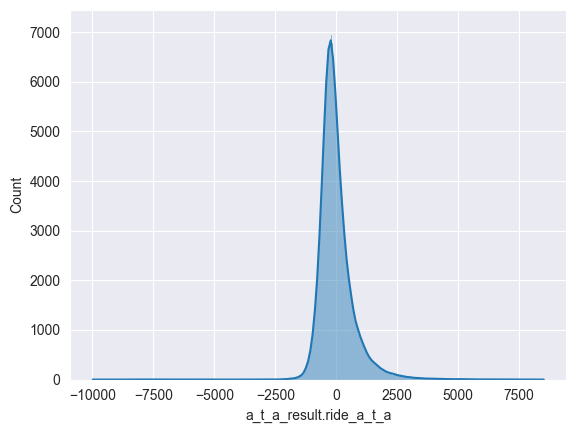

In [41]:
abs_seldon_err = rides_train_p4_y - ata_train_pred
sns.histplot(data=abs_seldon_err, kde=True)

In [45]:
b = abs_seldon_err[(abs_seldon_err > -500) & (abs_seldon_err < 500)]
len(b)

278992

In [48]:
abs_seldon_err.mean()

0.00016722192408691422

In [52]:
abs_seldon_err.std()

729.3257055447683

In [55]:
abs_seldon_err.kurtosis()

15.25579247019012

In [56]:
abs_seldon_err.skew()

1.8251790614599046

<AxesSubplot: ylabel='a_t_a_result.ride_a_t_a'>

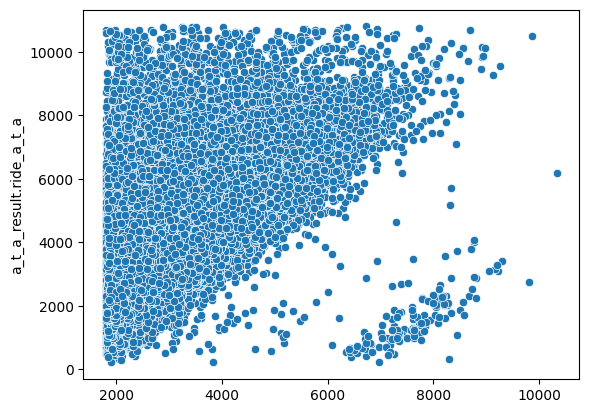

In [39]:
sns.scatterplot(x=rides_train_p4_x[:, 19], y=rides_train_p4_y)

<AxesSubplot: ylabel='a_t_a_result.ride_a_t_a'>

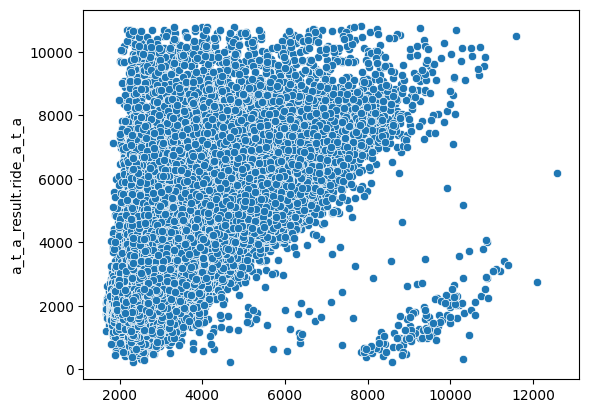

In [40]:
sns.scatterplot(x=ata_train_pred, y=rides_train_p4_y)

<AxesSubplot: ylabel='a_t_a_result.ride_a_t_a'>

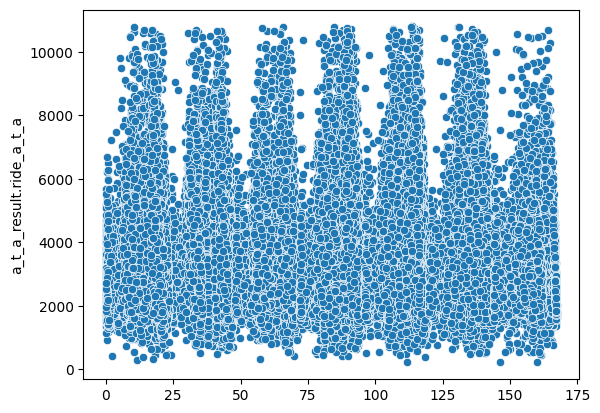

In [59]:
sns.scatterplot(x=rides_train_p4_x[:, 20], y=rides_train_p4_y)

In [121]:
source = rides_train_p4_x[:, 0:7]
source_h3 = ['source_h3_4_842cd4bffffffff','source_h3_4_842cd59ffffffff','source_h3_4_842cf31ffffffff','source_h3_4_842cf33ffffffff','source_h3_4_842cf35ffffffff','source_h3_4_842cf37ffffffff','source_h3_4_842cf3dffffffff',]
source_num = 7

destination = rides_train_p4_x[:, 7:19]
destination_h3 = ['dest_h3_4_842cd4bffffffff','dest_h3_4_842cd59ffffffff','dest_h3_4_842cf01ffffffff','dest_h3_4_842cf05ffffffff','dest_h3_4_842cf07ffffffff','dest_h3_4_842cf27ffffffff','dest_h3_4_842cf31ffffffff','dest_h3_4_842cf33ffffffff','dest_h3_4_842cf35ffffffff','dest_h3_4_842cf37ffffffff','dest_h3_4_842cf39ffffffff','dest_h3_4_842cf3dffffffff']
destination_num = 12

etas = []
seldons = []
atas = []

h3_names = []

for s in range(source_num):
    for d in range(destination_num):
        index = (source[:, s] == 1) & (destination[:, d] == 1)
        etas.append(rides_train_p4_x[:, 19][index])
        seldons.append(ata_train_pred[index])
        atas.append(rides_train_p4_y[index])
        h3_names.append((source_h3[s], destination_h3[d]))


In [116]:
for e in etas:
    print(len(e))

0
4
0
0
1
0
138
2
76
79
3
22
5
1
0
1
4
0
798
70
45
53
4
45
158
672
131
71
1577
104
236816
8924
19419
7524
9083
55868
5
67
2
1
25
3
11712
79
266
243
63
457
105
31
6
5
163
28
21523
219
2161
1411
427
6368
120
63
2
3
87
22
9782
224
1559
997
104
1241
19
15
6
24
180
10
17271
138
2393
478
691
6748


<AxesSubplot: ylabel='Count'>

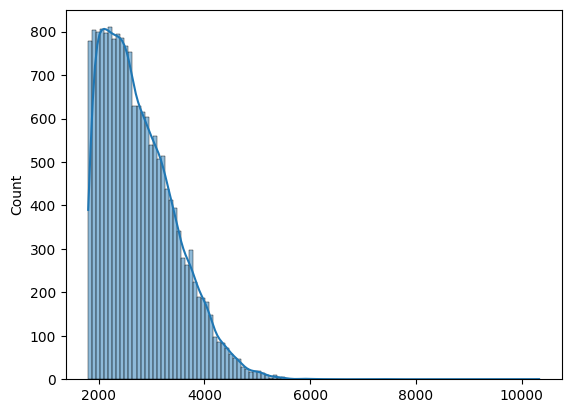

In [130]:
sns.histplot(data=etas[78], kde=True)

<AxesSubplot: xlabel='a_t_a_result.ride_a_t_a', ylabel='Count'>

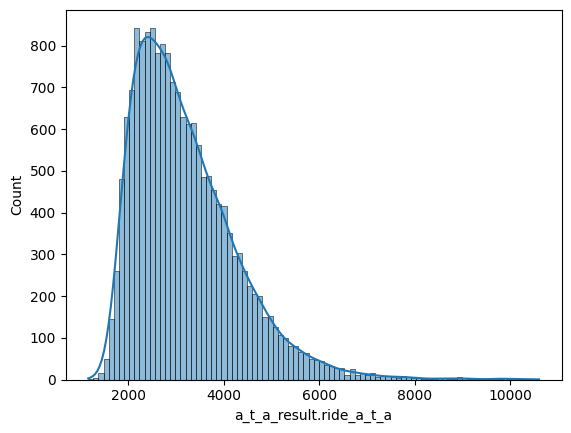

In [131]:
sns.histplot(data=atas[78], kde=True)

<AxesSubplot: ylabel='Count'>

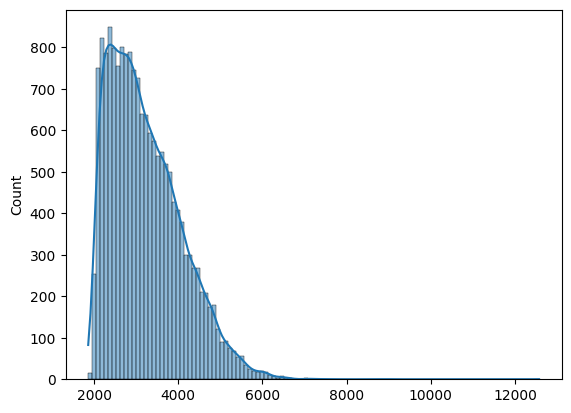

In [132]:
sns.histplot(data=seldons[78], kde=True)

In [133]:
h3_names[78]

('source_h3_4_842cf3dffffffff', 'dest_h3_4_842cf31ffffffff')

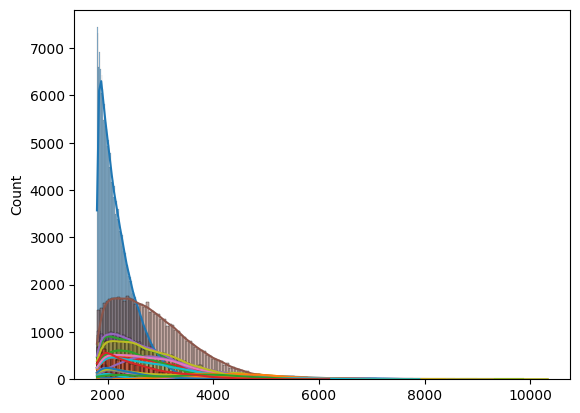

In [92]:
for d in distance:
    sns.histplot(data=d, kde=True)

<AxesSubplot: ylabel='Count'>

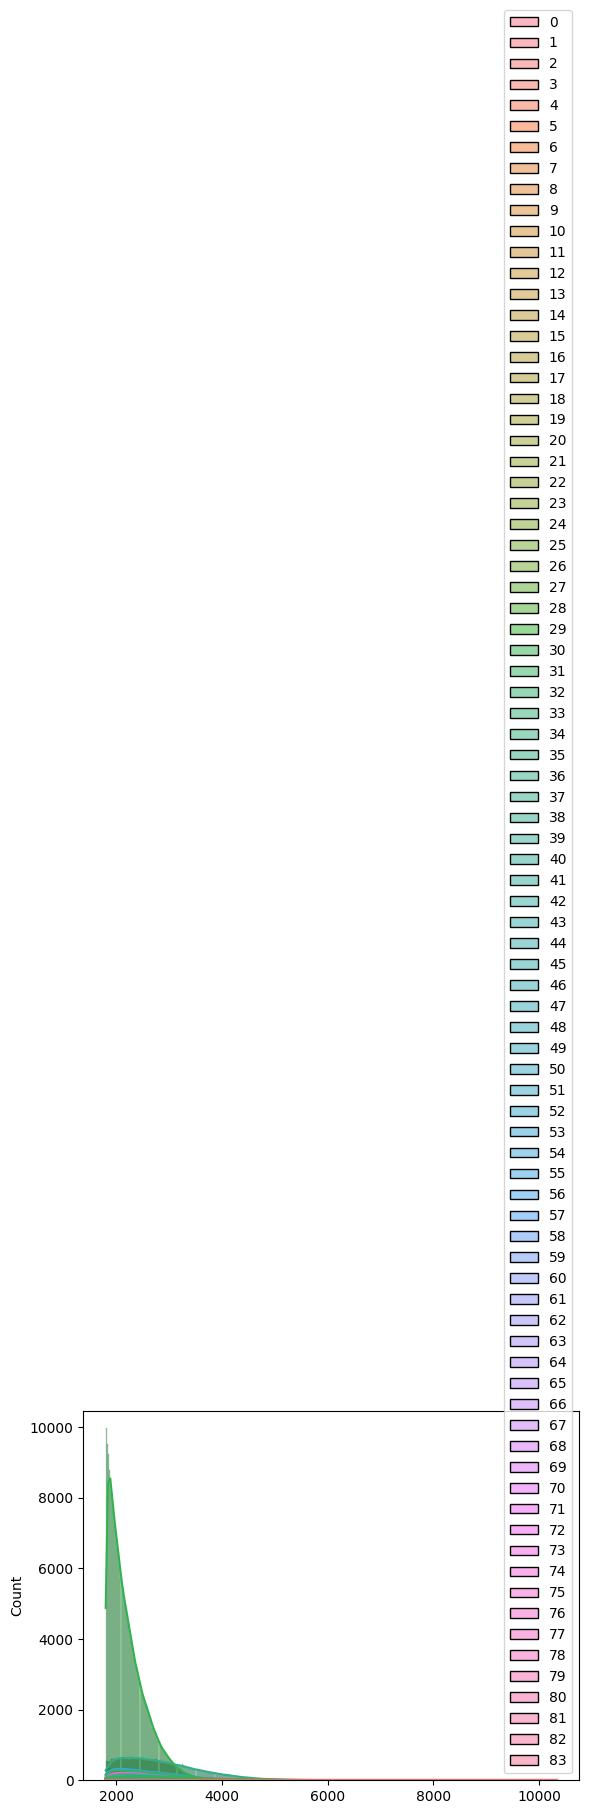

In [93]:
sns.histplot(data=distance, kde=True)

In [79]:
a = []
a.append([[1, 2, 3]])
a.append([[4, 5, 6]])
a

[[[1, 2, 3]], [[4, 5, 6]]]

In [41]:
eta = rides_train_p4_x[:, 19]

In [45]:
eta = np.sort(eta)
ata = np.sort(rides_train_p4_y)
seldon = np.sort(ata_train_pred)

In [48]:
eta['0']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<AxesSubplot: ylabel='Count'>

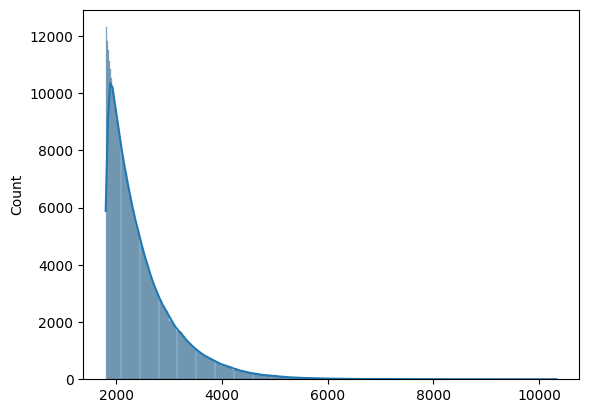

In [57]:
sns.histplot(data=eta, kde=True)

<AxesSubplot: ylabel='Count'>

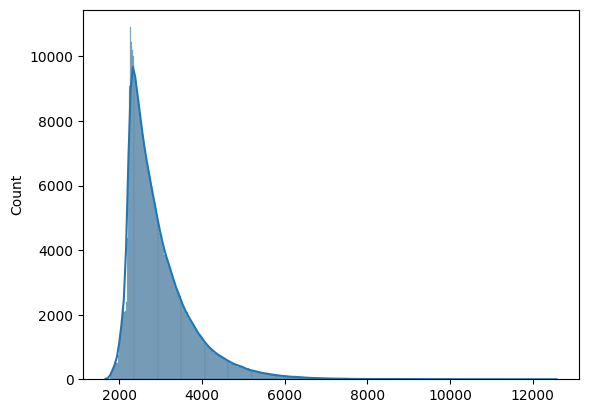

In [58]:
sns.histplot(data=seldon, kde=True)

<AxesSubplot: ylabel='Count'>

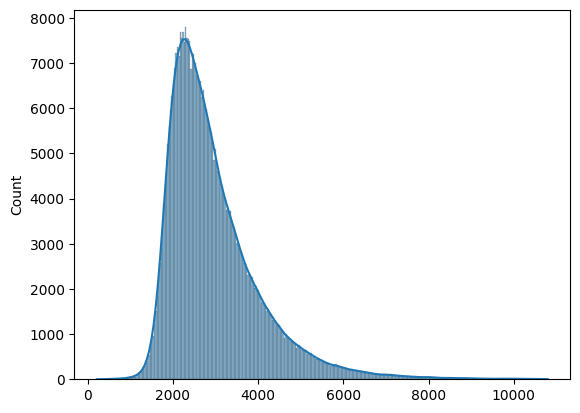

In [53]:
sns.histplot(data=ata, kde=True)

In [ ]:
plt.plot(eta)

In [ ]:
# %set_env AWS_ACCESS_KEY_ID=SokXIEc1g9vNqCJt4CSObyk6vumoOOPQ
# %set_env AWS_SECRET_ACCESS_KEY=QNyTpGhFjUTYSP9VKmfhpUizwKr0t8gk
# %set_env MLFLOW_S3_ENDPOINT_URL=https://minio-clustered-smapp-storage.apps.private.teh-1.snappcloud.io
#
# # create experiment
# %set_env MLFLOW_TRACKING_URI=https://mlflow.apps.private.okd4.teh-1.snappcloud.io/
# # mlflow experiments create --experiment-name elahe
#
# # run script under experiment
# %set_env MLFLOW_EXPERIMENT_NAME=elahe
# # cd save/
# # python test.py

In [ ]:
# ! echo $AWS_ACCESS_KEY_ID
# ! echo $AWS_SECRET_ACCESS_KEY
# ! echo $MLFLOW_S3_ENDPOINT_URL
# ! echo $MLFLOW_TRACKING_URI
# ! echo $MLFLOW_EXPERIMENT_NAME

In [ ]:
# with mlflow.start_run(run_name="regression") as run:
#     # Log the sklearn model and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=reg_p4,
#         artifact_path="regression",
#         registered_model_name="reg-model"
#     )

In [ ]:
# with mlflow.start_run(run_name="YOUR_RUN_NAME") as run:
#     params = {"n_estimators": 5, "random_state": 42}
#     sk_learn_rfr = RandomForestRegressor(**params)
#
#     # Log parameters and metrics using the MLflow APIs
#     mlflow.log_params(params)
#     mlflow.log_param("param_1", randint(0, 100))
#     mlflow.log_metrics({"metric_1": random(), "metric_2": random() + 1})
#
#     # Log the sklearn model and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=sk_learn_rfr,
#         artifact_path="sklearn-model",
#         registered_model_name="sk-learn-random-forest-reg-model"
#     )